In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# **IMPORT LIBRARIES** 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, cross_validate, validation_curve
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression


In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 170)
pd.set_option('display.max_rows', 20)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# FUNCTIONS

*  **Validation Curve Graphics**

In [4]:
def val_curve_params(model, X, y, param_name, param_range, scoring="roc_auc", cv=10):
    train_score, test_score = validation_curve(
        model, X=X, y=y, param_name=param_name, param_range=param_range, scoring=scoring, cv=cv)

    mean_train_score = np.mean(train_score, axis=1)
    mean_test_score = np.mean(test_score, axis=1)

    plt.plot(param_range, mean_train_score,
             label="Training Score", color='b')

    plt.plot(param_range, mean_test_score,
             label="Validation Score", color='r')

    plt.title(f"Validation Curve for {type(model).__name__}")
    plt.xlabel(f"Number of {param_name}")
    plt.ylabel(f"{scoring}")
    plt.tight_layout()
    plt.legend(loc='best')
    plt.show(block=True)  

* **Importance Graphics**

In [41]:
def plot_importance(model, features, num=len(X_train), save=True):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()

# Read Dataset

In [6]:
train = pd.read_csv("../input/titanic/train.csv")
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000,1,0,A/5 21171,7.250,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000,1,0,PC 17599,71.283,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000,0,0,STON/O2. 3101282,7.925,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000,1,0,113803,53.100,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.000,0,0,373450,8.050,NaN,S


In [7]:
test = pd.read_csv("../input/titanic/test.csv")
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.500,0,0,330911,7.829,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.000,1,0,363272,7.000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.000,0,0,240276,9.688,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.000,0,0,315154,8.662,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.000,1,1,3101298,12.287,NaN,S


In [8]:
tr = train.copy()
ts = test.copy()

# Train Values Analyze

In [9]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000,891.000,891.000,714.000,891.000,891.000,891.000
mean,446.000,0.384,2.309,29.699,0.523,0.382,32.204
std,257.354,0.487,0.836,14.526,1.103,0.806,49.693
min,1.000,0.000,1.000,0.420,0.000,0.000,0.000
25%,223.500,0.000,2.000,20.125,0.000,0.000,7.910
50%,446.000,0.000,3.000,28.000,0.000,0.000,14.454
75%,668.500,1.000,3.000,38.000,1.000,0.000,31.000
max,891.000,1.000,3.000,80.000,8.000,6.000,512.329


In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


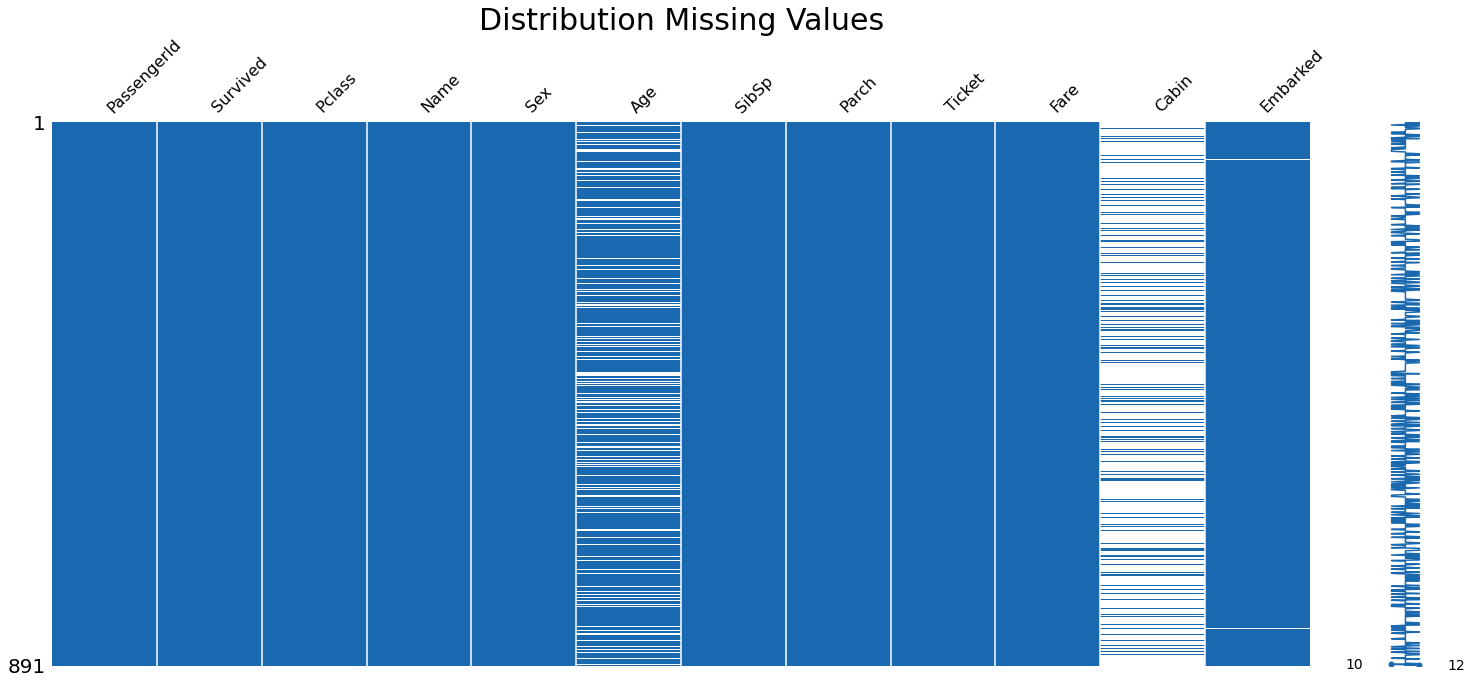

In [11]:
msno.matrix(train, color=(0.103, 0.410, 0.688))
plt.title('Distribution Missing Values',fontsize=30);

In [12]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

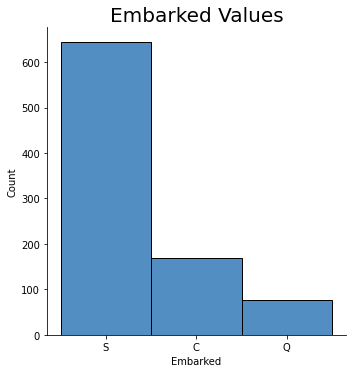

In [13]:
sns.displot(train['Embarked'],color=(0.103, 0.410, 0.688))
plt.title('Embarked Values', fontsize=20)
plt.show()

# Handling the Missing Values

In [14]:
# Deleting Cabin Data
train = train.drop(columns='Cabin', axis=1)

In [15]:
# Filling in Missing Values With the Mean Age
train['Age'].fillna(train['Age'].mean(), inplace=True)

In [16]:
#Filling in Missing Values With the Most Repeative Data
train["Embarked"] = train["Embarked"].fillna("S")

In [17]:
# Check for Missing Data
train.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

# Label Encoding

In [18]:
label_encoder = preprocessing.LabelEncoder()

train['Sex'] = label_encoder.fit_transform(train['Sex'])

train['Embarked'] = label_encoder.fit_transform(train['Embarked'])

train.drop(['Name', 'PassengerId', 'Ticket'], inplace=True, axis=1)

In [19]:
train.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,22.000,1,0,7.250,2
1,1,1,0,38.000,1,0,71.283,0
2,1,3,0,26.000,0,0,7.925,2
3,1,1,0,35.000,1,0,53.100,2
4,0,3,1,35.000,0,0,8.050,2
5,0,3,1,29.699,0,0,8.458,1
6,0,1,1,54.000,0,0,51.862,2
7,0,3,1,2.000,3,1,21.075,2
8,1,3,0,27.000,0,2,11.133,2
9,1,2,0,14.000,1,0,30.071,0


# Test Values Analyze

In [20]:
test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000,418.000,332.000,418.000,418.000,417.000
mean,1100.500,2.266,30.273,0.447,0.392,35.627
std,120.810,0.842,14.181,0.897,0.981,55.908
min,892.000,1.000,0.170,0.000,0.000,0.000
25%,996.250,1.000,21.000,0.000,0.000,7.896
50%,1100.500,3.000,27.000,0.000,0.000,14.454
75%,1204.750,3.000,39.000,1.000,0.000,31.500
max,1309.000,3.000,76.000,8.000,9.000,512.329


In [21]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [22]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

# Handling the Missing Values (Test-Data)

In [23]:
# Deleting Cabin Data
test = test.drop(columns='Cabin', axis=1)

In [24]:
# Filling in Missing Values With the Mean Age
test['Age'].fillna(test['Age'].mean(), inplace=True)

In [25]:
# Filling in Missing Values With the Mean Fare
test["Fare"].fillna(test['Fare'].mean(), inplace=True)

In [26]:
# Check for Missing Data
test.isnull().sum()

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

# Label Encoding (Test-Data)

In [27]:
label_encoder = preprocessing.LabelEncoder()

test['Sex'] = label_encoder.fit_transform(test['Sex'])

test['Embarked'] = label_encoder.fit_transform(test['Embarked'])

test.drop(['Name', 'PassengerId', 'Ticket'], inplace=True, axis=1)

In [28]:
test.head(10)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,1,34.500,0,0,7.829,1
1,3,0,47.000,1,0,7.000,2
2,2,1,62.000,0,0,9.688,1
3,3,1,27.000,0,0,8.662,2
4,3,0,22.000,1,1,12.287,2
5,3,1,14.000,0,0,9.225,2
6,3,0,30.000,0,0,7.629,1
7,2,1,26.000,1,1,29.000,2
8,3,0,18.000,0,0,7.229,0
9,3,1,21.000,2,0,24.150,2


**TRAIN-TEST SPLIT FOR TRAIN DATA**

In [29]:
X_train, X_test, y_train, y_test = train_test_split(train.drop("Survived", 
                                                               axis = 1),
                                                    train.Survived, 
                                                    test_size = 0.20,
                                                    random_state = 69)

# RANDOM FOREST

In [30]:
rf_model = RandomForestClassifier(random_state=69)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

In [31]:
y_pred_rf

array([1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1,
       0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0])

In [32]:
# Default Parameters
rf_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 69,
 'verbose': 0,
 'warm_start': False}

In [33]:
# Parameters Defined for the Test
rf_params = {"max_depth": [7, 8, 9, 10],
             "max_features": [4, 5, 6, 7],
             "min_samples_split": [3, 4, 5, 6, 7],
             "n_estimators": [80, 90, 100]}

In [34]:
rf_best_grid = GridSearchCV(rf_model, rf_params, cv=10, n_jobs=-1, verbose=True).fit(X_train, y_train)

Fitting 10 folds for each of 240 candidates, totalling 2400 fits


In [35]:
#Training the Model
rf_final = rf_model.set_params(**rf_best_grid.best_params_).fit(X_train, y_train)

In [36]:
rf_final

RandomForestClassifier(max_depth=7, max_features=7, min_samples_split=3,
                       n_estimators=90, random_state=69)

In [37]:
# Model Prepared with the Best Parameters
y_pred_rffinal = rf_final.predict(X_test)

In [38]:
y_pred_rffinal

array([1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 0])

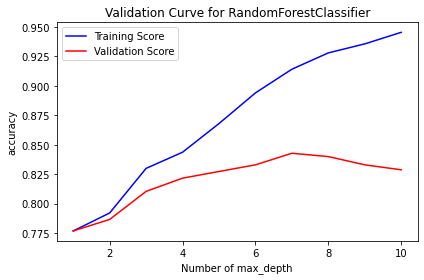

In [39]:
# Accuracy and Maximum Depth Curve
val_curve_params(rf_final, X_train, y_train, "max_depth", range(1, 11), scoring="accuracy")   

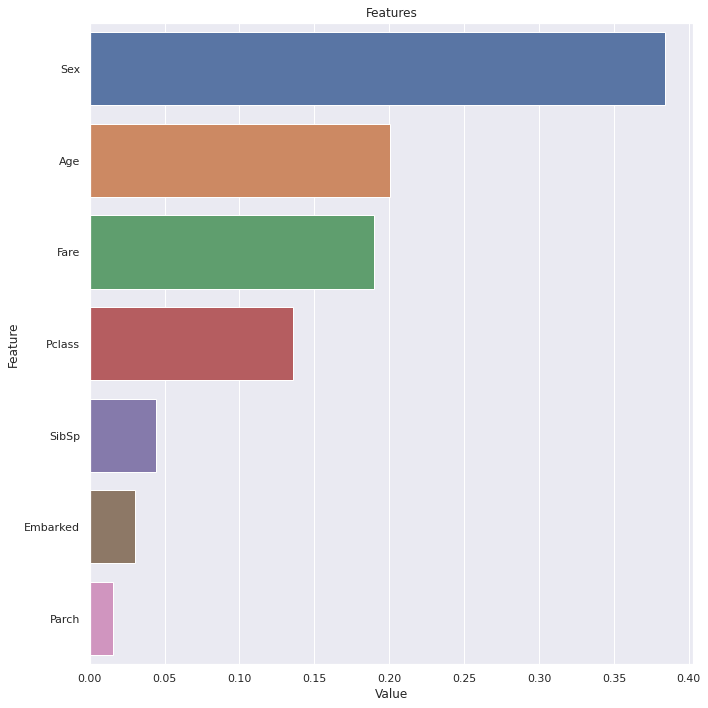

In [42]:
# Importance Graphics
plot_importance(rf_final, X_train) 

# GRADIENT BOOSTING MACHINE

In [43]:
gbm = GradientBoostingClassifier()
gbm.fit(X_train, y_train)
y_pred_gbm = gbm.predict(X_test)

In [44]:
y_pred_gbm

array([1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 0])

In [45]:
gbm_model = GradientBoostingClassifier(random_state=69)

In [46]:
# Default Parameters
gbm_model.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 69,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [47]:
# Parameters Defined for the Test
gbm_params = {"learning_rate": [0.01, 0.1],
              "max_depth": [6, 7, 9],
              "n_estimators": [150, 200, 250],
              "subsample": [0.3, 0.4, 0.6]}

In [48]:
#Finding the Best Parameters
gbm_best_grid = GridSearchCV(gbm_model, gbm_params, cv=5, n_jobs=-1, verbose=True).fit(X_train, y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


In [49]:
#Training the Model
gbm_final = gbm_model.set_params(**gbm_best_grid.best_params_, random_state=69, ).fit(X_train, y_train)

In [50]:
# Model Prepared with the Best Parameters
gbm_final

GradientBoostingClassifier(learning_rate=0.01, max_depth=7, n_estimators=150,
                           random_state=69, subsample=0.4)

In [52]:
# Model Prepared with the Best Parameters
y_pred_gbmfinal = gbm_final.predict(X_test)

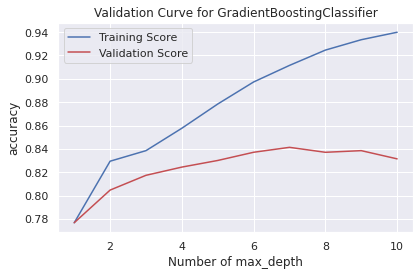

In [53]:
# Accuracy and Maximum Depth Curve
val_curve_params(gbm_final, X_train, y_train, "max_depth", range(1, 11), scoring="accuracy")   

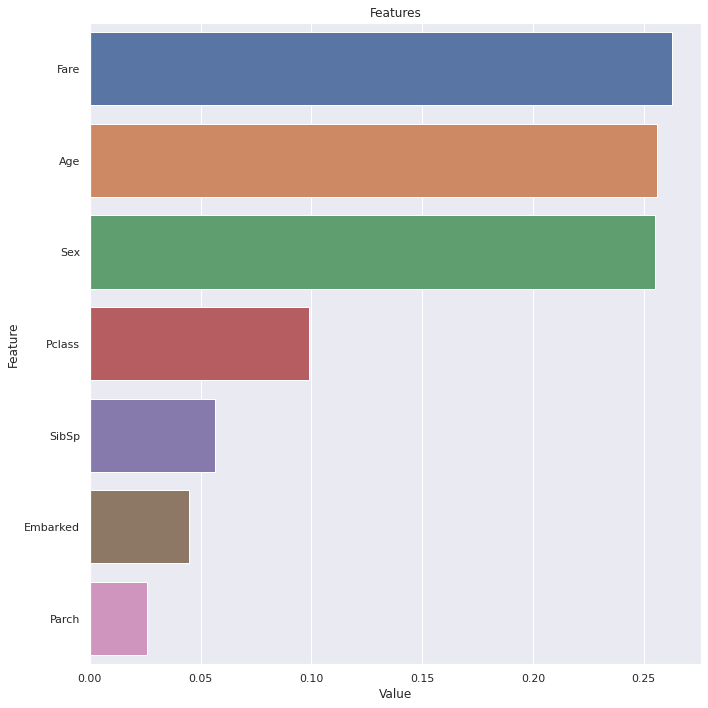

In [54]:
# Importance Graphics
plot_importance(gbm_final, X_train)

# EXTREME GRADIENT BOOSTING (XGBoost)

In [55]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

In [56]:
y_pred_xgb

array([1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0,
       1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 0])

In [57]:
# Default Model
xgboost_model = XGBClassifier(random_state=69, use_label_encoder=False)

In [58]:
xgboost_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=69,
              reg_alpha=None, reg_lambda=None, ...)

In [75]:
xgboost_params = {"learning_rate": [0.1, 0.01],
                  "max_depth": [5, 6, 7],
                  "n_estimators": [600, 700, 800],
                  "colsample_bytree": [0.5, 0.7, 1]}

In [76]:
xgboost_best_grid = GridSearchCV(xgboost_model, xgboost_params, cv=5, n_jobs=-1, verbose=True).fit(X_train, y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


In [77]:
xgboost_best_grid.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.01,
 'max_depth': 5,
 'n_estimators': 700}

In [78]:
xgboost_final = xgboost_model.set_params(**xgboost_best_grid.best_params_, random_state=69).fit(X_train, y_train)

In [79]:
xgboost_final

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=700,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=69,
              reg_alpha=0, reg_lambda=1, ...)

In [80]:
# Model Prepared with the Best Parameters
y_pred_xgbfinal = xgboost_final.predict(X_test)

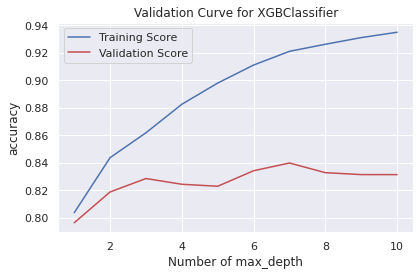

In [74]:
# Accuracy and Maximum Depth Curve
val_curve_params(xgboost_final, X_train, y_train, "max_depth", range(1, 11), scoring="accuracy")   

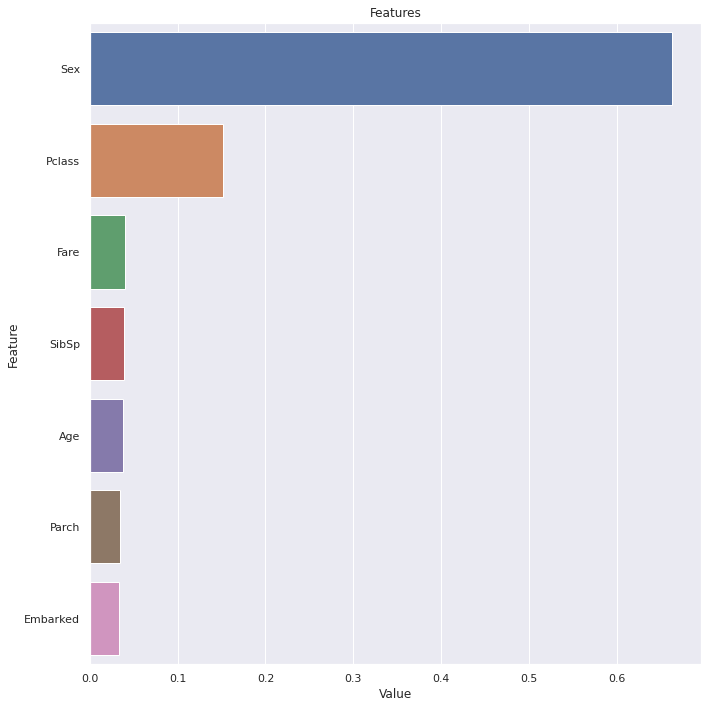

In [81]:
plot_importance(xgboost_final, X_train)

# PREDICTIONS

In [82]:

models = ["Random Forest","Random Forest - Grid",
          "Gradient Boosting Machine","Gradient Boosting Machine - Grid",
          "XGBoost","XGBoost- Grid"]

test_acc = [
    accuracy_score(y_test, y_pred_rf),
    accuracy_score(y_test, y_pred_rffinal),
    accuracy_score(y_test, y_pred_gbm),
    accuracy_score(y_test, y_pred_gbmfinal),
    accuracy_score(y_test, y_pred_xgb),
    accuracy_score(y_test, y_pred_xgbfinal)
]

train_acc = [
    accuracy_score(y_train, rf_model.predict(X_train)),
    accuracy_score(y_train, rf_final.predict(X_train)),
    accuracy_score(y_train, gbm.predict(X_train)),
    accuracy_score(y_train, gbm_final.predict(X_train)),
    accuracy_score(y_train, xgb.predict(X_train)),
    accuracy_score(y_train, xgboost_final.predict(X_train))
]

pd.DataFrame({
    
    "Model":models,
    "Train Accuracy": train_acc,
    "Test Accuracy": test_acc
    
})

,Model,Train Accuracy,Test Accuracy
0,Random Forest,0.912,0.799
1,Random Forest - Grid,0.912,0.849
2,Gradient Boosting Machine,0.890,0.838
3,Gradient Boosting Machine - Grid,0.916,0.844
4,XGBoost,0.965,0.827
5,XGBoost- Grid,0.893,0.827


**RF**

In [83]:
rf = RandomForestClassifier()
model = rf.fit(train.drop("Survived",axis = 1), train.Survived)
y_predprob = model.predict_proba(test)[:,1]
ypred = [1 if i > 0.4 else 0 for i in y_predprob]

ts["Survived"] = ypred
submissionsvc = ts[["PassengerId", "Survived"]]
submissionsvc.to_csv("submissionrf.csv",columns = ["PassengerId", "Survived"] , index = None)

**RF - GRID**

In [84]:
rf = rf_final
model = rf.fit(train.drop("Survived",axis = 1), train.Survived)
y_predprob = model.predict_proba(test)[:,1]
ypred = [1 if i > 0.4 else 0 for i in y_predprob]

ts["Survived"] = ypred
submissionsvc = ts[["PassengerId", "Survived"]]
submissionsvc.to_csv("submissionrf-grid.csv",columns = ["PassengerId", "Survived"] , index = None)

**GBM**

In [85]:
gbm = GradientBoostingClassifier()
model = gbm.fit(train.drop("Survived",axis = 1), train.Survived)
y_predprob = model.predict_proba(test)[:,1]
ypred = [1 if i > 0.5 else 0 for i in y_predprob]

ts["Survived"] = ypred
submissionsvc = ts[["PassengerId", "Survived"]]
submissionsvc.to_csv("submissiongbm.csv",columns = ["PassengerId", "Survived"] , index = None)

**GBM - GRID**

In [89]:
gbm = gbm_final
model = gbm.fit(train.drop("Survived",axis = 1), train.Survived)
y_predprob = model.predict_proba(test)[:,1]
ypred = [1 if i > 0.5 else 0 for i in y_predprob]

ts["Survived"] = ypred
submissionsvc = ts[["PassengerId", "Survived"]]
submissionsvc.to_csv("submission.csv",columns = ["PassengerId", "Survived"] , index = None)

**XGB**

In [87]:
xgb = XGBClassifier()
model = xgb.fit(train.drop("Survived",axis = 1), train.Survived)
y_predprob = model.predict_proba(test)[:,1]
ypred = [1 if i > 0.5 else 0 for i in y_predprob]

ts["Survived"] = ypred
submissionsvc = ts[["PassengerId", "Survived"]]
submissionsvc.to_csv("submissionxgb.csv",columns = ["PassengerId", "Survived"] , index = None)

**XGB - GRID**

In [88]:
xgb = xgboost_final
model = xgb.fit(train.drop("Survived",axis = 1), train.Survived)
y_predprob = model.predict_proba(test)[:,1]
ypred = [1 if i > 0.5 else 0 for i in y_predprob]

ts["Survived"] = ypred
submissionsvc = ts[["PassengerId", "Survived"]]
submissionsvc.to_csv("submissionxgb-grid.csv",columns = ["PassengerId", "Survived"] , index = None)

# THANK YOU